<h1 align="center">INFO621 - RAG - XAI - [Mistral PEFT tune & Compare] </h1>

## The tuned model is saved here Giving 73.5% accuracy (base mistral gives ~ 56 - 58%):
https://huggingface.co/sauravverma78/mistral7bInstruct02_fever_trained


## Another trained model giving 73.2% accuracy
https://huggingface.co/sauravverma78/mistral7bInstruct02_fever_trained_73pc_2



### This notebook / code was developed on COLAB - A100 GPU.

### The code here uses Mistral-7B model for the PEFT Fine tuning and evaluate RAG pipeline with tuned model
- Refer README.md for more details.
- And the Project report for combined study and analysis

- Steps are mentioned in README.md.
    -  Execute the Next cell for pip installs. 
    -  This install all packages required on COLAB
    -  **Note : During package install, Colab would ask for "restart" of session. Please do so. And run the install cell again.**
    -  Requires access to your local google drive.
    -  Would need your HuggingFace Token (to download the models)

    -  change `hub_save_path = ` below if you want to save tuned model to your huggingFace cloud. If you want to use the saved trained model, then use 'sauravverma78/mistral7bInstruct02_fever_trained' to load it.
    
  


#### Some steps take a long time to run, 
 - We suggest running cell by cell manually to see the executions, as some steps are time consuming

### The code here uses Mistral-7B model and trl, peft modules for PEFT Tuning.
- Refer README.md for more details.
- And the Project report for combined study and analysis


### Core Libraries used in the project
 - **Core-ML/NLP**: torch, transformers, accelerate, bitsandbytes, sentence-transformers.
 - **Fine-Tuning**: peft, trl [PART OF ANOTHER NOTEBOOK]
 - **RAG & Vector Store**: langchain, chromadb, faiss-gpu
 - **Evaluation**: scikit-learn, **RAGAS**
 - **XAI**: captum, lime, shap, ,lit
 - **Data Handling**: datasets, numpy
 - **Utilities**: tqdm, psutil, asyncio, nest_asyncio, openai, tiktoken, matplotlib, seaborn

In [ ]:
# RUN FOR COLAB


!pip install accelerate==1.6.0 #0.27.2
!pip install transformers==4.51.3
!pip install datasets==3.5.1
!pip install sentence-transformers==3.4.1
!pip install langchain # ==0.1.15

# !pip install langchain-core==0.1.41
!pip install langchain-community
!pip install langchainhub
!pip install chromadb==1.0.5
!pip install openai

# Fine Tuning
!pip install peft==0.8.2
!pip install trl==0.16.1 # 0.7.10
!pip install bitsandbytes
!pip install loralib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
# 📦 Standard Library
import os
import re
import gc
import time
import asyncio
import warnings
from typing import List, Optional, Any
from collections import Counter
import numpy as np

# Visualization
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import display, HTML

# Scientific & ML Libraries
import numpy as np
import torch
from torch.nn import functional as F
import seaborn as sns
from tqdm import tqdm
import psutil
# import shap
# from lime.lime_text import LimeTextExplainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

#  Transformers / HuggingFace
import accelerate
import bitsandbytes as bnb
from transformers import (
    pipeline, AutoTokenizer, AutoModelForCausalLM,
    AutoModelForSeq2SeqLM, GenerationConfig, TrainingArguments,
    BitsAndBytesConfig
)
from sentence_transformers import SentenceTransformer
# from captum.attr import Saliency, IntegratedGradients
# from captum.attr import visualization as viz

#  LangChain Core
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
# from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.llms.base import LLM
from langchain.schema import LLMResult, Document
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain.callbacks.manager import CallbackManager, CallbackManagerForLLMRun
from langchain.chat_models import ChatOpenAI
from langchain.schema.retriever import BaseRetriever

#  LangChain Community Extensions
# from langchain_huggingface import HuggingFacePipeline, HuggingFaceEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings

#  LangChain Core v1-style
from langchain_core.retrievers import BaseRetriever as LCBaseRetriever
from langchain_core.documents import Document as LCDocument
from langchain_core.pydantic_v1 import Field

#  RAGAS
# from ragas import evaluate, EvaluationDataset
# from ragas.run_config import RunConfig
# from ragas.testset import TestsetGenerator
# from ragas.llms import LangchainLLMWrapper
# from ragas.embeddings import BaseRagasEmbeddings, LangchainEmbeddingsWrapper
# from ragas.metrics import (
#     LLMContextRecall, Faithfulness, FactualCorrectness,
#     AnswerCorrectness, ResponseRelevancy, ContextPrecision
# )

#  Datasets
from datasets import Dataset, load_dataset

#  Notebook Setup
import nest_asyncio
nest_asyncio.apply()

# Fine Tuning
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model

#  Suppress Warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.")


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# ENABLE THIS TO MAKE FINE TUNING LESS RANDOM

# import random
# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(42)

In [ ]:
colab_mode = True
local_mode = False
local_path = None
hub_save_path = "sauravverma78/mistral7bInstruct02_fever_trained"

In [ ]:
if (colab_mode):
    from google.colab import drive
    drive.mount('/content/drive')
    local_path = "/content/drive/MyDrive/models"
elif local_mode:

    # Adjust according to your host.
    local_path = '/Users/saurav1/python/masters/arizona/2nd/mlapps621/project/local_models'


Mounted at /content/drive


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `test` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `test`


In [ ]:
from langchain.callbacks.manager import CallbackManager

# Langchain callback for detailed logging
CALLBACK_VERBOSE_LOGGING=True



## ==== 1) Load FEVER Dataset ====

In [ ]:
# dataset1 = load_dataset("fever/feverous")
dataset1 = load_dataset("copenlu/fever_gold_evidence")

README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/96.9M [00:00<?, ?B/s]

valid.jsonl:   0%|          | 0.00/6.47M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/6.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/228277 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15935 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16039 [00:00<?, ? examples/s]

In [ ]:
dataset1

DatasetDict({
    train: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 228277
    })
    validation: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 15935
    })
    test: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 16039
    })
})

In [ ]:
train = dataset1['train']
validation = dataset1['validation']
test = dataset1['test']

## ==== 2) Cleaned FEVER Dataset ====

####  For the preprocessing of the dataset we manage to remove:

- all words after the last dot (they don't belong to the sentence but are a kind of most relevant terms) ------> ?????
- all the digits that we found at the beginning of the sentence (also with the tab)
- all the parenthesis token strings
- all the words that contains characters that are not in ASCII format (for example the ones retrieved by the Wikipedia page for the pronunciation of a given name or term)
- all the punctuation


In [ ]:


# Special tokens like "-LRB-" etc.
PARENTHESIS_TOKENS = {"-LRB-", "-LSB-", "-RRB-", "-RSB-"}

# Check for non-ASCII characters
def contains_non_ascii(s):
    return any(ord(ch) > 127 for ch in s)

# Remove parenthesis tokens
def remove_parenthesis(sentence):
    return ' '.join([word for word in sentence.split() if word not in PARENTHESIS_TOKENS])

# Clean up a single sentence
def clean_sentence(sentence):
    if not isinstance(sentence, str):
        return ""

    # 1. Remove trailing fragments after first period (optional)
    sentence = re.sub(r'(\.[^.]*)$', '.', sentence)

    # 2. Remove leading digits + tab
    sentence = re.sub(r'^\d+\t', '', sentence)

    # 3. Remove special parenthesis tokens like -LRB-, -RRB-, etc.
    sentence = re.sub(r'-LRB-|-RRB-|-LSB-|-RSB-', '', sentence)

    # 4. Remove words with non-ASCII characters
    words = sentence.split()
    words = [word for word in words if all(ord(ch) < 128 for ch in word)]
    sentence = ' '.join(words)

    # 5. Remove punctuation and underscores but KEEP dots and commas
    sentence = re.sub(r'[^\w\s.,]', '', sentence)

    # 6. Normalize whitespace
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = re.sub(r'[^\w\s.,]', '', sentence)
    sentence = re.sub(r'[_]', ' ', sentence)

    # 7. Lowercase
    sentence = sentence.lower().strip()
    if not (sentence.endswith(".")):
        sentence +=  "."
    return sentence

In [ ]:
# === Extract and Clean Evidence Sentences ===
def clean_evidences(ds, dedup = True, max_len=500, typ="train"):
    evidence_sentences = []
    total = 0
    for example in ds:
        if 'evidence' in example and example['evidence']:
            total += 1
            for group in example['evidence']:
                full_sent = ""
                for ev in group:
                    if isinstance(ev, str) and not ev.isdigit():
                        sentence = clean_sentence(ev)
                        if sentence:
                            full_sent += sentence + " "
                if full_sent.strip():
                    evidence_sentences.append(full_sent.strip()[0:max_len])

    # Deduplicate
    if dedup:
      evidence_sentences = list(set(evidence_sentences))
    print("total ", total)
    print(f"Total cleaned evidence dedup sentences : {len(evidence_sentences)}, of {typ}")
    for e in evidence_sentences[:2]:
        print("Sample:", e)
    return evidence_sentences

In [ ]:
# Use only 10,000 for our purpose.
train_10K=train.select(range(10000))
train_cl_10K = clean_evidences(train_10K)


total  10000
Total cleaned evidence dedup sentences : 8399, of train
Sample: 1991 nba finals. this series would mark the end of the lakers showtime era and the beginning of the bulls dynasty .
Sample: naomi watts. since then , watts has portrayed valerie plame wilson in the biographical drama fair game 2010 and helen gandy in clint eastwood s biographical drama j. edgar 2011 .


In [ ]:
train_10K[2]

{'claim': 'Eleveneleven was founded by a chef.',
 'label': 'REFUTES',
 'evidence': [['Eleveneleven',
   '0',
   'eleveneleven is a record label founded in 2010 by Mike Hamlin , Ellen DeGeneres and her production company , A Very Good Production , in association with longtime affiliate Warner Bros. .']],
 'id': 'c457e9fef2f45fc423cbdb67ff321f67',
 'verifiable': 'VERIFIABLE',
 'original_id': 213765}

In [ ]:
train_cl_10K[2]

'new mutants. the new mutants are a group of teenaged mutant superheroesintraining appearing in american comic books published by marvel comics .'

In [ ]:
# Use 1000 for validation
validation_1K=validation.select(range(1000))
validation_cl_1K = clean_evidences(validation_1K, typ="validation")


total  1000
Total cleaned evidence dedup sentences : 925, of validation
Sample: give me back my hometown. give me back my hometown is a song cowritten and recorded by american country music singer eric church .
Sample: omar khadr. khadr was released on bail in may 2015 pending an appeal of his u.s. conviction after the alberta court of appeal refused to block his release as had been requested by the canadian government .


In [ ]:
# Use 1000 for test
test_1K=test.select(range(1000))
test_cl_1K = clean_evidences(test_1K, typ="test")

total  1000
Total cleaned evidence dedup sentences : 910, of test
Sample: stephen king. he has written nearly 200 short stories , most of which have been collected in book collections .
Sample: jimi hendrix. in 1961 , he enlisted in the u.s. army and trained as a paratrooper in the 101st airborne division he was granted an honorable discharge the following year .


## === 3. Embedding Model ===

In [ ]:
def get_embedding_model(model_name: str = "BAAI/bge-m3", save_path: str = "./local_models/bge-m3"):
    """
    Downloads and saves a sentence-transformer model if not already saved.
    Returns a HuggingFaceEmbeddings instance for LangChain.

    Args:
        model_name (str): Name of the Hugging Face model.
        save_path (str): Local directory to save/load the model.

    Returns:
        HuggingFaceEmbeddings: Embedding wrapper usable with LangChain retrievers.
    """
    if not os.path.exists(save_path):
        print(f"Downloading and saving model '{model_name}' to: {save_path}")
        model = SentenceTransformer(model_name)

        model.save(save_path)
    else:
        print(f"Loading embedding model from local path: {save_path}")

    model = HuggingFaceEmbeddings(model_name=save_path)
    sentence_transformer = SentenceTransformer(save_path)

    return model, sentence_transformer


# Load directly
    # embeddings = HuggingFaceEmbeddings(model_name=model_name)
    # sentence_transformer = SentenceTransformer(model_name)
    # return embeddings, sentence_transformer

In [ ]:
embedding_model, sentence_transformer = get_embedding_model(
    model_name="BAAI/bge-m3",
    save_path=local_path + "/bge-m3"
)

Loading embedding model from local path: /content/drive/MyDrive/models/bge-m3


## === 4. Chroma Vector Store ===



In [ ]:
def monitor_memory():
    mem = psutil.virtual_memory()
    return f"Memory used: {mem.used // (1024**2)} MB / {mem.total // (1024**2)} MB ({mem.percent}%)"

def get_or_create_chroma_db(texts, embedding_model, persist_dir, batch_size=100):
    if os.path.exists(persist_dir):
        print("Loading existing Chroma DB from disk...")
        return Chroma(persist_directory=persist_dir, embedding_function=embedding_model)
    else:
        # return Chroma.from_texts(texts, embedding=embedding_model, persist_directory=persist_dir)
        print("Creating new Chroma DB and saving to disk...")
        print("given size ", len(texts))
        os.makedirs(persist_dir, exist_ok=True)

        # Create Chroma DB (empty)
        vectorstore = Chroma(embedding_function=embedding_model, persist_directory=persist_dir)

        for i in tqdm(range(0, len(texts), batch_size), desc="Indexing to Chroma"):
            batch = texts[i:i + batch_size]
            if batch:
                try:
                    vectorstore.add_texts(batch)
                    vectorstore.persist()  # flush to disk
                except Exception as e:
                    print(f"Skipped batch {i}: {e}")
                    raise
            gc.collect()  # clean up memory

        return vectorstore


In [ ]:
# TRAIN Chroma DB
evidence_sentences = train_cl_10K
vectorstore = get_or_create_chroma_db(
    texts=evidence_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_train_10K"
)
print (len(vectorstore))

Loading existing Chroma DB from disk...
8399


In [ ]:
# VALIDATE Chroma DB
validation_sentences = validation_cl_1K
vectorstore_validate = get_or_create_chroma_db(
    texts=validation_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_validate_1K"
)
print (len(validation_sentences))

Loading existing Chroma DB from disk...
925


### === 4. QueryRetriever Setup ===



In [ ]:
# Vanilla retriever worked better than MultiQuery one and provided relevant evidence on top.
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
# Validate retriever
retriever_validate = vectorstore_validate.as_retriever(search_kwargs={"k": 5})

## === 5. Reasoning Prompt ===

In [ ]:

prompt_template = PromptTemplate.from_template("""
You are a classifier. Based ONLY on the evidence below, select the correct label for the claim:
SUPPORTS, REFUTES, or NOT ENOUGH INFO. Respond with only one word. If the claim entity is mentioned but no positive link exists, treat as REFUTES.

Claim: {question}

Evidence:
{context}

Your answer:
""")


In [ ]:

def extract_label_from_answer_block(text):
    """
    Extracts the final label from the line after 'Your answer:' in the model's response.
    Assumes label is one of: SUPPORTS, REFUTES, NOT ENOUGH INFO
    """
    valid_labels = {"SUPPORTS", "REFUTES", "NOT ENOUGH INFO"}

    lines = text.strip().upper().splitlines()

    for i, line in enumerate(lines):
        if "YOUR ANSWER" in line:
            # Try next non-empty line
            for next_line in lines[i+1:]:
                candidate = next_line.strip(" .").upper()
                if candidate in valid_labels:
                    return candidate
                elif candidate:  # skip empty lines but stop if line has content
                    break
    return "UNKNOWN"


## === 6 RAG Chain ===

**Async Retrieval**
- Class that performs threshold-based evidence filtering for the RAG pipeline:
- Instead of naively using top 5 documents, it selects top K/5 which show cosine_simuilarity > threshold of 0.6
- 0.6 was empirically selected after doing analysis over 100s of claim outputs.
- Participates in end to end Chain Logging (retrival logging)

In [ ]:
from langchain.callbacks.base import BaseCallbackHandler
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import LLMResult

class VerboseCallbackHandler(BaseCallbackHandler):
    """
    A detailed callback handler for monitoring and logging RAG pipeline steps, 
    including chain execution, retriever outputs, LLM prompts, LLM responses, 
    streaming tokens, and token usage.

    This handler is primarily used for debugging and analyzing pipeline behavior 
    by printing human-readable logs during retrieval, generation, and chain execution.

    Args:
        enabled (bool, optional): 
            Whether verbose logging is globally enabled. Defaults to True.
        
        print_prompt (bool, optional): 
            Whether to print LLM input prompts. Defaults to True.
        
        print_docs (bool, optional): 
            Whether to print retrieved documents' contents. Defaults to True.

    Attributes:
        enabled (bool): 
            Controls whether any logging is performed.
        
        print_prompt (bool): 
            Controls whether LLM prompts are displayed.
        
        print_docs (bool): 
            Controls whether retrieved documents are displayed.
        
        _timers (dict): 
            Internal dictionary to track timing information for different pipeline stages.

    """
    
    def __init__(self, enabled=True, print_prompt=True, print_docs=True):
        self.enabled = enabled
        self.print_prompt = print_prompt
        self.print_docs = print_docs
        self._timers = {}

    def _start_timer(self, key):
        self._timers[key] = time.time()
    
    def _end_timer(self, key):
        if key in self._timers:
            elapsed = time.time() - self._timers[key]
            print(f"⏱️ [Time] {key} took {elapsed:.2f} sec")
    
    def on_chain_start(self, serialized, inputs, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print("\n [Chain Start]")
        print(f"  ➤ Query: {inputs.get('query', inputs)}")
        self._start_timer("Chain")
        
    def on_chain_end(self, outputs, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        self._end_timer("Chain")
        print(" [Chain End]")
        print(f"  ➤ Output: {outputs}")

    def on_retriever_end(self, documents, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print(f" [Retriever] Retrieved {len(documents)} documents:")
        for i, doc in enumerate(documents[:3]):
            print(f"  {i+1}. {doc.page_content[:150]}...")

    def on_llm_start(self, serialized, prompts, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        print("\n [LLM Prompt]")
        print(prompts[0][:1000])  # Truncate long prompts
        self._start_timer("LLM")
        
    def on_llm_end(self, response: LLMResult, **kwargs):
        if not CALLBACK_VERBOSE_LOGGING:
            return
        self._end_timer("LLM")            
        print("\n [LLM Response]")
        print(response.generations[0][0].text.strip())

    def on_llm_new_token(self, token: str, **kwargs):
        if CALLBACK_VERBOSE_LOGGING:
            print(token, end='', flush=True)

    def on_llm_end_streaming(self, **kwargs):
        if v:
            print()  # for clean newline after token stream

    def on_llm_token_usage(self, token_usage: dict, **kwargs):
        if  CALLBACK_VERBOSE_LOGGING:
            print(f"\n [Token Usage] prompt: {token_usage.get('prompt_tokens')}, "
                  f"completion: {token_usage.get('completion_tokens')}, "
                  f"total: {token_usage.get('total_tokens')}")
    
    def log_docs(self, documents):
        if not CALLBACK_VERBOSE_LOGGING: return
        print(f"[Retriever] Retrieved {len(documents)} documents:")
        for i, doc in enumerate(documents[:3]):
            print(f"  {i+1}. {doc.page_content[:150]}...")            


In [ ]:


from typing import List, Optional, Any
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.pydantic_v1 import Field
from sklearn.metrics.pairwise import cosine_similarity
import time

class ThresholdFilteredRetriever(BaseRetriever):
    """
    A retriever that filters documents retrieved from a base retriever 
    based on a cosine similarity threshold using a query embedding.

    This retriever works by:
      1. Retrieving candidate documents using a base retriever.
      2. Computing embeddings for the query and documents.
      3. Filtering documents whose cosine similarity to the query 
         is below a specified threshold.
      4. Falling back to selecting top-k documents if no documents 
         pass the threshold.

    This improves retrieval precision by ensuring only semantically 
    relevant documents (above a threshold) are considered.

    Args:
        base_retriever (BaseRetriever): 
            The underlying retriever to fetch initial candidate documents.
        
        embedding_model (Any): 
            Embedding model providing `embed_query()` and `embed_documents()` 
            methods for vectorization.
        
        threshold (float, optional): 
            Minimum cosine similarity score to retain a document. Defaults to 0.65.
        
        fallback_topk (int, optional): 
            Number of top documents to fallback to if none meet the threshold. Defaults to 1.
        
        callback_handler (Optional[Any], optional): 
            Optional callback handler for logging document retrieval details.

    Attributes:
        total_queries (int): 
            Total number of queries processed.
        
        total_docs_returned (int): 
            Total number of documents returned across all queries.
        
        total_retrieval_time (float): 
            Total time spent on retrieval operations (in seconds).
    """
    
    base_retriever: Any = Field()
    embedding_model: Any = Field()
    threshold: float = Field(default=0.65)
    fallback_topk: int = Field(default=1)
    callback_handler: Optional[Any] = Field(default=None)

    total_queries: int = Field(default=0)
    total_docs_returned: int = Field(default=0)
    total_retrieval_time: float = Field(default=0.0)

    def _get_relevant_documents(self, query: str) -> List[Document]:
        start = time.time()
        self.total_queries += 1
    
        # Support LCEL-wrapped retriever
        raw_docs = self.base_retriever.invoke(query)
        doc_texts = [doc.page_content for doc in raw_docs]
    
        if not doc_texts:
            return []
    
        query_emb = self.embedding_model.embed_query(query)
        doc_embs = self.embedding_model.embed_documents(doc_texts)
        sim_scores = cosine_similarity([query_emb], doc_embs)[0]
    
        filtered = [(raw_docs[i], sim_scores[i]) for i in range(len(raw_docs)) if sim_scores[i] >= self.threshold]
    
        if not filtered:
            sorted_docs = sorted(zip(raw_docs, sim_scores), key=lambda x: -x[1])
            filtered = sorted_docs[:self.fallback_topk]
    
        final_docs = [doc for doc, _ in filtered]
        self.total_docs_returned += len(final_docs)
        self.total_retrieval_time += (time.time() - start)
    
        if self.callback_handler:
            self.callback_handler.log_docs(final_docs)
    
        return final_docs

    async def _aget_relevant_documents(self, query: str) -> List[Document]:
        return self._get_relevant_documents(query)

    def print_metrics(self):
        if self.total_queries > 0:
            avg_time = self.total_retrieval_time / self.total_queries
            avg_docs = self.total_docs_returned / self.total_queries
        else:
            avg_time = avg_docs = 0
        print(f"\n Retrieval Metrics")
        print(f"  ➤ Total Queries: {self.total_queries}")
        print(f"  ➤ Avg Time per Query: {avg_time:.3f} sec")
        print(f"  ➤ Avg Docs Returned: {avg_docs:.2f}")



In [ ]:
gc.collect()
CALLBACK_VERBOSE_LOGGING=False

# === 7. PEFT Tuning ====





In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model
from datasets import Dataset
import torch

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)


In [ ]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

# Load in 4-bit for QLoRA
model_raw_4bit = AutoModelForCausalLM.from_pretrained(
    model_id,
    # local_path + "/mistral-7b-v0.2",
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype="auto"
)


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [ ]:
tokenizer_raw = AutoTokenizer.from_pretrained(model_id)
tokenizer_raw.pad_token = tokenizer_raw.eos_token
tokenizer_raw.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
# EXPERIMENTAL
# for param in model_raw_4bit.parameters():
#   param.requires_grad = False  # freeze the model - train adapters later
#   if param.ndim == 1:
#     # cast the small parameters (e.g. layernorm) to fp32 for stability
#     param.data = param.data.to(torch.float32)

# model.gradient_checkpointing_enable()  # reduce number of stored activations
# model.enable_input_require_grads()

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:

peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    # target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj"],
    # target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
    target_modules="all-linear",
)

# Apply PEFT (QLoRA)
model_raw_4bit = get_peft_model(model_raw_4bit, peft_config)



In [ ]:
print_trainable_parameters(model_raw_4bit)

In [ ]:
# print(model_raw_4bit)

In [ ]:
def clean_evidences_for_training(ds, max_len=700, typ="train"):
    evidence_sentences = []

    for example in ds:
        merged = ""
        if 'evidence' in example and example['evidence']:
            for group in example['evidence']:
                for ev in group:
                    if isinstance(ev, str) and not ev.isdigit():
                        sentence = clean_sentence(ev)
                        if sentence:
                            merged += sentence + " "
        merged = merged.strip()[:max_len]
        evidence_sentences.append(merged)

    print(f"Prepared {len(evidence_sentences)} evidence blocks ({typ})")
    return evidence_sentences

### Training Prompt with few shot samples

In [ ]:
# Use RAG claim + context + label as training examples. Here's a format transformer:
def format_for_sft(samples, evidences):
  formatted = []
  for sam, e in zip (samples, evidences):
    claim    = sam["claim"]
    evidence = e
    label    = sam["label"]
        # get encoded label
    # label    = label_mapping[sam["label"]]
    #  EXPERIMENTAL
    few_shot_examples = (
        "Example 1:\n"
        "Claim: The moon is made of cheese.\n"
        "Evidence: Scientific studies show the moon is made of rock and dust.\n"
        "Your answer: REFUTES\n\n"
        "Example 2:\n"
        "Claim: The sun is hot.\n"
        "Evidence: The sun's surface temperature is about 5,500°C.\n"
        "Your answer: SUPPORTS\n\n"
        "Example 3:\n"
        "Claim: Gabrielle Union won an Oscar for her role in Bring It On.\n"
        "Evidence: Gabrielle Union starred in Bring It On, a 2000 American teen cheerleading comedy film.\n"
        "Your answer: NOT ENOUGH INFO\n\n"
    )
    text = (
          f"You are a classifier. Based ONLY on the evidence below, "
          f"select the correct label for the claim: SUPPORTS, REFUTES, or NOT ENOUGH INFO.\n\n"

          f"{few_shot_examples}"

          f"Claim: {claim}\n\n"
          "Evidence:\n"
          f"{evidence}\n\n"
          f"Your answer: {label}"
    )
    # formatted.append({"text": text, "label": label}) # EXPERIMENTAL
    formatted.append({"text": text})

  return formatted


In [ ]:
train_5000 = train.select(range(1000)).to_list()
train_evidences_5000 = clean_evidences_for_training(train_5000)
assert len(train_5000) == len(train_evidences_5000), "Mismatch in samples vs evidences"
train_dataset = Dataset.from_list(format_for_sft(train_5000, train_evidences_5000))

Prepared 1000 evidence blocks (train)


In [ ]:
# print(train_100[1])
train_dataset[1]

{'text': "You are a classifier. Based ONLY on the evidence below, select the correct label for the claim: SUPPORTS, REFUTES, or NOT ENOUGH INFO.\n\nExample 1:\nClaim: The moon is made of cheese.\nEvidence: Scientific studies show the moon is made of rock and dust.\nYour answer: REFUTES\n\nExample 2:\nClaim: The sun is hot.\nEvidence: The sun's surface temperature is about 5,500°C.\nYour answer: SUPPORTS\n\nExample 3:\nClaim: Gabrielle Union won an Oscar for her role in Bring It On.\nEvidence: Gabrielle Union starred in Bring It On, a 2000 American teen cheerleading comedy film.\nYour answer: NOT ENOUGH INFO\n\nClaim: Gabrielle Union was in a movie.\n\nEvidence:\ngabrielle union. she costarred in film the birth of a nation 2016 , and next appeared in almost christmas 2016 and sleepless 2017 .\n\nYour answer: SUPPORTS"}

In [ ]:
validate_100 = validation.select(range(900)).to_list()
validate_evidences_100 = clean_evidences_for_training(validate_100, typ="validate")
validate_dataset = Dataset.from_list(format_for_sft(validate_100, validate_evidences_100))


Prepared 900 evidence blocks (validate)


In [ ]:
# train_dataset = train_dataset.map(encode_labels)
# validate_dataset = validate_dataset.map(encode_labels)


## NOTE We omitted evaluation optimization during Training Due to lack of Excessive Memory (GPU) resources it needs. This effects the Training efficacy

In [ ]:


training_args = TrainingArguments(
    output_dir="./mistral-qlora-output",
    per_device_train_batch_size=4,
    warmup_steps=10,
    learning_rate=5e-4,
    logging_steps=100,
    num_train_epochs=5,
    eval_strategy= 'no', #'epoch',

    # EVALUATION OPTMIZATION OMITTED BELOW. ENABLE IF ENOUGH GPU MEMORY
    # eval_steps=1000,
    # metric_for_best_model="eval_loss" ,
    # gradient_checkpointing=True,  # Enable
    # max_grad_norm=0.3,
    # gradient_accumulation_steps=1,
    # save_strategy="epoch",
    # load_best_model_at_end=True,

    logging_strategy="steps",
    save_total_limit=2,
    weight_decay=0.01,
    bf16=True,
    # fp16=True,
    optim="adamw_torch",
    report_to="none",
)



from sklearn.metrics import f1_score


# TODO EXPERIMENTAL
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = logits.argmax(-1)

#     return {
#         "accuracy": accuracy_score(labels, predictions),
#         "f1_macro": f1_score(labels, predictions, average="macro"),
#         "f1_weighted": f1_score(labels, predictions, average="weighted")
#     }

trainer = SFTTrainer(
    model=model_raw_4bit,
    # compute_metrics=compute_metrics,
    args=training_args,
    train_dataset=train_dataset,
    # eval_dataset=validate_dataset,
    peft_config=peft_config)



Converting train dataset to ChatML:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/900 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Train PEFT model

trainer.train()


Step,Training Loss
100,0.426100
200,0.420200
300,0.319800
400,0.250700
500,0.257900
600,0.140000
700,0.150000
800,0.111300
900,0.077800
1000,0.076600


TrainOutput(global_step=1250, training_loss=0.18694677810668944, metrics={'train_runtime': 531.713, 'train_samples_per_second': 9.404, 'train_steps_per_second': 2.351, 'total_flos': 6.584322036262502e+16, 'train_loss': 0.18694677810668944})

### Training 

- The PEFT (QLoRA) fine-tuning on Mistral-7B using just 1,000 samples shows strong convergence, with training loss dropping from 0.42 to ~0.04 over 5 epochs.
- The final average training loss is 0.1869, indicating effective adaptation even with a small dataset.
- This confirms that parameter-efficient tuning can yield meaningful learning with limited supervision.

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6012894511222839,
 'eval_runtime': 32.6765,
 'eval_samples_per_second': 27.543,
 'eval_steps_per_second': 3.458}

In [ ]:
model_raw_trained = trainer.model
model_merged = model_raw_trained.merge_and_unload()

### Saved Tuned Model to HuggingFace 

In [ ]:
# #  Push to hub

# Comment to not save and directly use the model in memory
model_merged.push_to_hub(hub_save_path, safe_serialization=True)
tokenizer_raw.push_to_hub(hub_save_path)

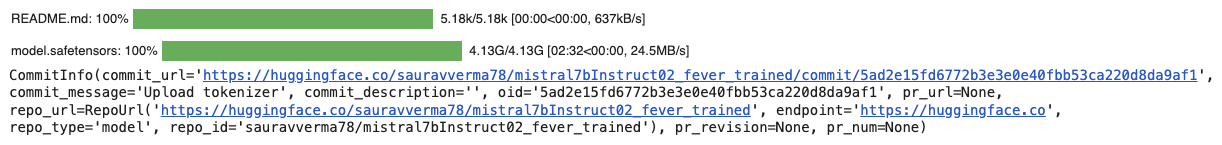

In [ ]:
# #  Push to google drive
# model_merged.model.save_pretrained(local_path + "/mistral7bInstruct02_fever_trained", safe_serialization=True)
# tokenizer.save_pretrained(local_path + "/mistral7bInstruct02_fever_trained")

In [ ]:
# # load from hub
# model_merged = AutoModelForCausalLM.from_pretrained(
#     hub_save_path, device_map="auto",
#     trust_remote_code=True,
#     torch_dtype="auto")
# tokenizer_raw = AutoTokenizer.from_pretrained(hub_save_path)

### RAG chain prep using PEFT tuned model

In [ ]:
from transformers import pipeline
from langchain.llms import HuggingFacePipeline

peft_pipeline = pipeline(
    "text-generation",
    model=model_merged,
    tokenizer=tokenizer_raw,
    max_new_tokens=512,
    pad_token_id=tokenizer_raw.eos_token_id,  # this prevents the warning
    temperature=0.1,
    do_sample=True,
    top_p=0.95,
    # return_full_text=False
)

llm_peft = HuggingFacePipeline(pipeline=peft_pipeline)

Device set to use cuda:0


In [ ]:
callback = ConsoleCallbackHandler()

# Toggle logging
CALLBACK_VERBOSE_LOGGING=True

callback_handler = VerboseCallbackHandler(enabled=CALLBACK_VERBOSE_LOGGING)
callback_manager = CallbackManager([callback_handler])

# llm.callback_manager = callback_manager
retriever = retriever.with_config(callbacks=[callback_handler])
retriever_validate = retriever_validate.with_config(callbacks=[callback_handler])
llm_peft = llm_peft.with_config(callbacks=[callback_handler])

# Wrap your retriever with threshold logic
filtered_retriever_train_peft = ThresholdFilteredRetriever(
    base_retriever=retriever,
    embedding_model=embedding_model,
    threshold=0.6,
    fallback_topk=1,
    callback_handler=callback_handler
)

tagged_rag_chain_train_peft = RetrievalQA.from_chain_type(
    llm=llm_peft,
    retriever=filtered_retriever_train_peft,
    chain_type="stuff",
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt_template},
    callbacks=[callback_handler],  #  Add callback
    verbose=False
)

filtered_retriever_validate_peft = ThresholdFilteredRetriever(
    base_retriever=retriever_validate,
    embedding_model=embedding_model,
    threshold=0.6,
    fallback_topk=1,
    callback_handler=callback_handler
)


tagged_rag_chain_validate_peft = RetrievalQA.from_chain_type(
	    llm=llm_peft,
	    retriever=filtered_retriever_validate_peft,
	    chain_type="stuff",
	    return_source_documents=True,
	    chain_type_kwargs={"prompt": prompt_template},
      callbacks=[callback_handler],  #  Add callback
      verbose=False
)


In [ ]:
CALLBACK_VERBOSE_LOGGING=True
sample = validation_1K[0]
claim = sample['claim']
result = tagged_rag_chain_validate_peft({"query": claim})
print("actual", sample['label'])
CALLBACK_VERBOSE_LOGGING=False


🔷 [Chain Start]
  ➤ Query: Jackie (2016 film) was directed by Peter Jackson.
📄 [Retriever] Retrieved 5 documents:
  1. jackie 2016 film. jackie is a 2016 biographical drama film directed by pablo and written by noah oppenheim ....
  2. underdog film. directed by frederik du chau and written by joe piscatella , adam rifkin , and craig a. williams , the film stars jim belushi , peter d...
  3. black reel awards of 2016. creed was the big winner of the night winning five awards including outstanding picture , director ryan coogler and actor m...
📄 [Retriever] Retrieved 1 documents:
  1. jackie 2016 film. jackie is a 2016 biographical drama film directed by pablo and written by noah oppenheim ....

🧠 [LLM Prompt]

You are a classifier. Based ONLY on the evidence below, select the correct label for the claim:
SUPPORTS, REFUTES, or NOT ENOUGH INFO. Respond with only one word. If the claim entity is mentioned but no positive link exists, treat as REFUTES.

Claim: Jackie (2016 film) was direc

# == PEFT Model RAG Evaluation ==

##  Evaluate RAG ACCURACY

### Getting 73.5% accuracy - compared to untuned base mistral (55 - 58%)

In [ ]:
from tqdm.notebook import tqdm  # Notebook-friendly

CALLBACK_VERBOSE_LOGGING = False

def evaluate_rag_chain_accuracy(claim_dataset, rag_chain, label_field="label", num_samples=1000):
    """
    Evaluates the RAG chain on a dataset of claims.

    Args:
        claim_dataset: HuggingFace Dataset or list of dicts with 'claim' and 'label'
        rag_chain: LangChain RetrievalQA object
        label_field: field containing true label (default: "label")
        num_samples: number of claims to evaluate

    Returns:
        accuracy, classification_report
    """

    true_labels = []
    pred_labels = []

    for sample in tqdm(claim_dataset.select(range(num_samples)), desc="Evaluating", leave=True):
        claim = sample["claim"]
        true_label = sample[label_field].upper()

        try:
            result = rag_chain({"query": claim})
            model_output = result["result"]
            pred_label = extract_label_from_answer_block(model_output)
        except Exception as e:
            print(f" Error for claim: {claim[:50]}... | {str(e)}")
            pred_label = "UNKNOWN"

        true_labels.append(true_label)
        pred_labels.append(pred_label)

        if CALLBACK_VERBOSE_LOGGING:
            print(true_label, pred_label)

    # Evaluation
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"\n✅ Accuracy: {accuracy:.4f}")
    print("\n📊 Classification Report:\n", classification_report(true_labels, pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"],
                yticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"], cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return pred_labels, true_labels


Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]


✅ Accuracy: 0.7350

📊 Classification Report:
                  precision    recall  f1-score   support

NOT ENOUGH INFO       0.67      0.74      0.70       135
        REFUTES       0.81      0.66      0.73       137
       SUPPORTS       0.75      0.81      0.78       128
        UNKNOWN       0.00      0.00      0.00         0

       accuracy                           0.73       400
      macro avg       0.56      0.55      0.55       400
   weighted avg       0.74      0.73      0.74       400



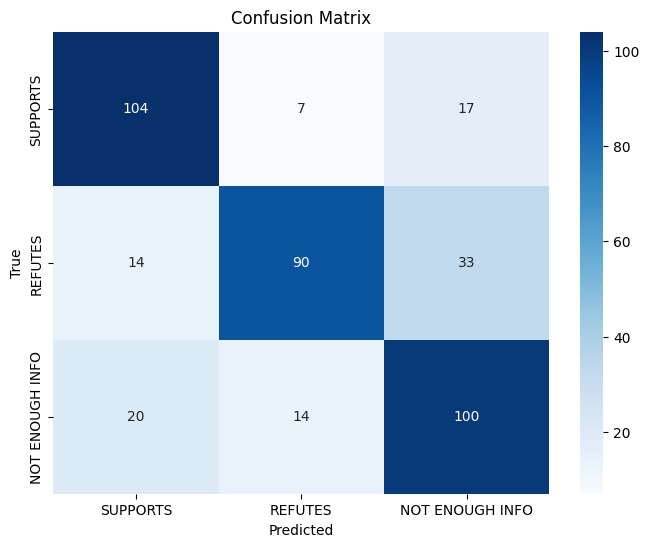

In [ ]:
# Load dataset
ds = validation_1K

# Run evaluation
pred_labels,true_labels = evaluate_rag_chain_accuracy(ds, tagged_rag_chain_validate_peft, num_samples=400)


#### Insights

- Strong overall accuracy (73.5%): The PEFT-tuned Mistral model shows balanced performance across all three classes, a major improvement over its base version.

- Best performance on SUPPORTS (F1: 0.78): High recall (0.81) and precision (0.75) show the model reliably identifies supported claims with minimal misclassification.

- REFUTES is moderately handled (F1: 0.73): While precision is high (0.81), recall (0.66) suggests some refuting claims are still misclassified, often as NEI.

- NEI classification is solid (F1: 0.70): Achieving 74% recall on NEI shows the model effectively abstains when evidence is insufficient - a critical trait for trustworthy fact-checking.


## === Visualizations ===

### Pie Chart for Prediction Label Distribution for RAG based output

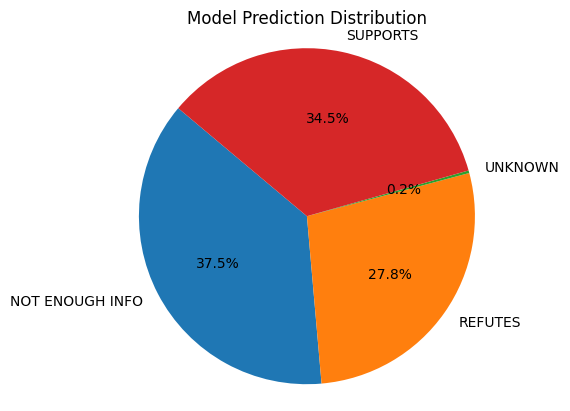

In [ ]:
from collections import Counter
label_counts = Counter(pred_labels)
labels = list(label_counts.keys())
sizes = list(label_counts.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Model Prediction Distribution")
plt.axis('equal')
plt.show()


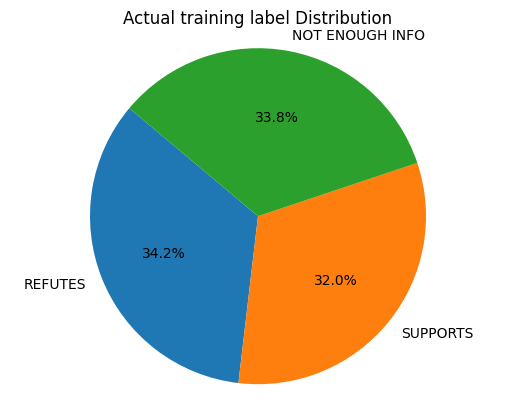

In [ ]:
from collections import Counter
label_counts = Counter(true_labels)
labels = list(label_counts.keys())
sizes = list(label_counts.values())

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Actual training label Distribution")
plt.axis('equal')
plt.show()


### True vs Predicted Label Distribution for RAG based output

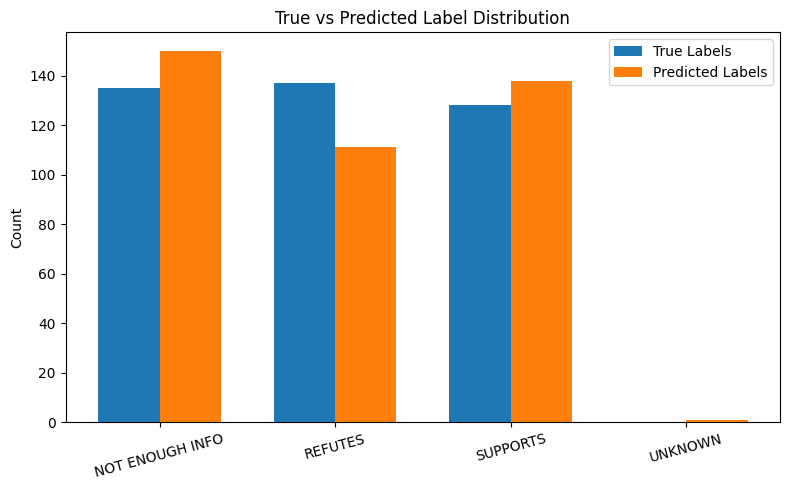

In [ ]:
# Count frequencies
true_counts = Counter(true_labels)
pred_counts = Counter(pred_labels)

# Ensure consistent label order
all_labels = sorted(list(set(true_counts.keys()) | set(pred_counts.keys())))

true_values = [true_counts.get(label, 0) for label in all_labels]
pred_values = [pred_counts.get(label, 0) for label in all_labels]

# Bar plot setup
x = np.arange(len(all_labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, true_values, width, label="True Labels")
plt.bar(x + width/2, pred_values, width, label="Predicted Labels")

plt.ylabel("Count")
plt.title("True vs Predicted Label Distribution")
plt.xticks(x, all_labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()


#### Insights

- Overall balance is strong: Despite some class-level skew, the model maintains a relatively balanced prediction distribution, which is impressive for a multi-class fact verification task.
- Huge improvements on the base model

## Another Model we trained gave similar - 73.2% accuracy
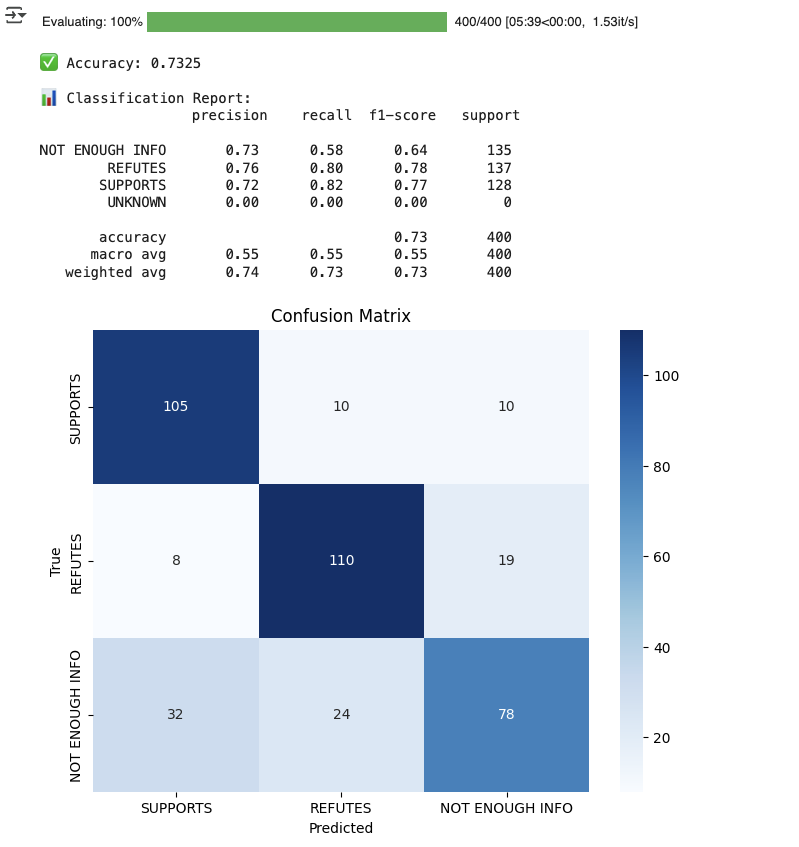

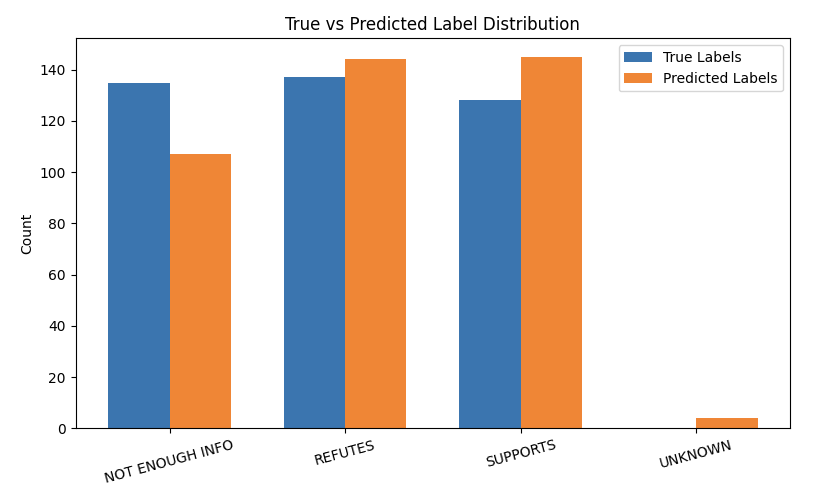